In [2]:
import lightkurve as lk
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
import scipy
import pandas as pd 
from scipy import interpolate

In [1]:
#lk.seismology.estimate_deltanu_acf2d?

In [3]:
#lk.seismology.estimate_numax_acf2d?

In [4]:
#Cycles
    #21
        #cycle_21 = []
        
        #Start 1 March 1976
        #End 1 September 1986
        
    #22
        #cycle_22 = [2446674.5,2450296.5]
        
        #Start: 1 September 1986 2446674.5
        #End: 1 August 1996 2450296.5
        
    #23
        cycle_23 = [2450296.5,2454801.5]
        
        #Start: 1 August 1996 2450296.5
        #End: 1 December 2008 2454801.5
        
    #24
        cycle_24 = [2454801.5,2458940.5]
        
        #Start: 1 December 2008 2454801.5
        #End: 1 May 2020 2458970.5
        #NOTE: Due to dataset limitation, only analyzed up to 2458940.5
        

# BiSON Surface Velocity Preprocessing

In [5]:
hdul = fits.open('data/allsites-alldata-waverage-fill.fits')

hdul.info()

tsdata = hdul[0].data
#         SIMPLE  =                    T / Written by IDL:  Tue Jan 19 11:22:20 2016      
#         BITPIX  =                  -64 /Real*8 (double precision)                       
#         NAXIS   =                    2 /                                                
#         NAXIS1  =                    2 /                                                
#         NAXIS2  =             24455519 /                                                
DSTART =        2442778.50000 #Data start (Julian)      1/1/1976 0:00:00                        
DEND   =        2458940.50000 #Data end (Julian)        4/1/2020 0:00:00                       
#         STATIONS= 'na ca cb su iz la lb mo' /Stations Used                              
#         METHOD  = 'waverage'           /Overlap Method                                  
#         CADENCE = '40      '           /Timeseries Cadence                              
#         N-THRES =                   80 /Noise Rejection Threshold                       
#         GAPFILL =                    1 /GapFill                                         
#         FILL    =             0.638866 /Duty Cycle   
#
#         ~2160 datapoints per day


Filename: data/allsites-alldata-waverage-fill.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (2, 34909918)   float64   


In [6]:
def getSV(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[1]

In [7]:
def getSV_index(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[0]

In [8]:
print(getSV(cycle_23))
print(getSV_index(cycle_23))

[ 0.52007627  0.87248993  0.11934945 ...  0.25079036 -1.0275805
 -0.95429337]
[2450296.50033958 2450296.50080254 2450296.50126551 ... 2454801.49915418
 2454801.49961714 2454801.50008011]


# Sunspot Preprocessing

In [9]:
sunspot_Day = np.genfromtxt('data/SN_d_tot_V2.0.csv',delimiter=';')
SNSTART_Day = 2385070.5
SNEND_day = 2459000.5

sunspot_Month = np.genfromtxt('data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = sunspot_Month[828:]

In [10]:
def getSN_Day(cycle):
    if cycle[1] >= SNEND_day:
        cycle[1] = SNEND_day
    cycle = np.subtract(cycle, SNSTART_Day)
    sn = sunspot_Day.T[4][int(cycle[0]):int(cycle[1])]
    
    npout = [[0,0]]
    for i in range(len(sn)):
        npout = np.append(npout,[[i+SNSTART_Day+cycle[0],sn[i]]],0)
    npout = npout[1:]
    return npout

In [11]:
def getSNAverage(cycle,length):
    
    npout = [[0,0]]
    total = 0
    valid_count = 0
    start = cycle[0][0]
    for i in range(len(cycle)):
        if cycle[i][1] >= 0:
            total += cycle[i][1]
            valid_count += 1
        if (i+1) % length < 1 or i == len(cycle)-1:
            npout = np.append(npout,[[start,total/valid_count]],0)
            total = 0
            valid_count = 0
            if i == len(cycle)-1:
                break
            start = cycle[i+1][0]
    npout = npout[1:]
    return npout

In [12]:
getSN_Day(cycle_23)

array([[2.4502965e+06, 2.6000000e+01],
       [2.4502975e+06, 3.1000000e+01],
       [2.4502985e+06, 3.1000000e+01],
       ...,
       [2.4547985e+06, 0.0000000e+00],
       [2.4547995e+06, 0.0000000e+00],
       [2.4548005e+06, 0.0000000e+00]])

In [13]:
getSNAverage(getSN_Day(cycle_23),365)

array([[2.45029650e+06, 1.45643836e+01],
       [2.45066150e+06, 6.19232877e+01],
       [2.45102650e+06, 1.21704110e+02],
       [2.45139150e+06, 1.69175342e+02],
       [2.45175650e+06, 1.53487671e+02],
       [2.45212150e+06, 1.78747945e+02],
       [2.45248650e+06, 1.29030137e+02],
       [2.45285150e+06, 7.85397260e+01],
       [2.45321650e+06, 5.33808219e+01],
       [2.45358150e+06, 3.17945205e+01],
       [2.45394650e+06, 1.95780822e+01],
       [2.45431150e+06, 6.09041096e+00],
       [2.45467650e+06, 2.98400000e+00]])

# Broomhall2015 Replication

In [14]:
#To study variations associated with the 11- year cycle, 
#we have used 114 consecutive time series of 365-days length that are separated by 91.25 days.

In [15]:
def getNumax(time,freq):
    lc = lk.LightCurve(time=time.tolist(),flux=freq.tolist())
    lc = lc.remove_nans()
    pg = lc.to_periodogram(method='lombscargle', normalization='psd',minimum_frequency=1000, maximum_frequency=5000)
    #ax = pg.plot()
    pg.smooth(method='boxkernel', filter_width=1.)#.plot(ax=ax, label='Smoothed', c='red', lw=2)
    #ax.axvline(pg.frequency_at_max_power.value, lw=2, ls='dashed')
    snr = pg.flatten()
    seis = snr.to_seismology()
    numax = seis.estimate_numax()
    numax = float(str(numax)[0:7])
    return numax

In [16]:
getNumax(getSV_index(cycle_23)[100000:200000],getSV(cycle_23)[100000:200000])

3035.0

In [19]:
def tsNumax(time,freq,length,interval):
    length = int(length * 2160)
    interval = int(interval * 2160)
    
    npout = [[0,0]]
    for start in range(0,len(time),interval):
        if start + length >= len(time):
            length = len(time) - start
        npout = np.append(npout,[[time[start],getNumax(time[start:start+length],freq[start:start+length])]],0)
    npout = npout[1:]
    return npout

In [20]:
def getResidual(data):
    data.T[1] -= np.average(data.T[1])
    return data

# Graphing

In [21]:
#Interpolation
def interpolate(data, smoothness):
    from scipy import interpolate
    x_new = np.linspace((data[0][0])-1,int(data[-1][0])+1,smoothness)
    a_BSpline = interpolate.make_interp_spline(data.T[0],data.T[1])
    y_new = a_BSpline(x_new)
    return x_new,y_new

In [22]:
def bestfit(data):
    return None

In [23]:
numax_cycle_23_182 = tsNumax(getSV_index(cycle_23),getSV(cycle_23),182.5,91.25)
#print(numax_cycle_23)

In [ ]:
# print(numax_cycle_23_182)
print(getResidual(numax_cycle_23_182)[0])

In [ ]:
numax_cycle_23_365 = tsNumax(getSV_index(cycle_23),getSV(cycle_23),365,91.25)
#print(numax_cycle_23)

In [ ]:
print(numax_cycle_23_365[2])

In [26]:
numax_cycle_23_91 = tsNumax(getSV_index(cycle_23),getSV(cycle_23),91.25,22.8125)

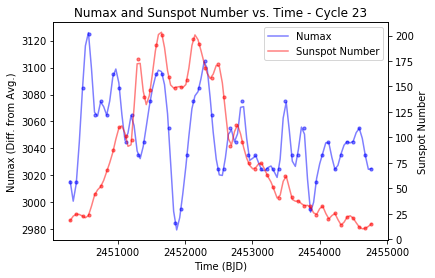

In [24]:
#Output SV vs. Time Cycle 24
datax_SV = numax_cycle_23_182.T[0]
#datay_SV = getResidual(numax_cycle_24_182[:-1]).T[1]
datay_SV = numax_cycle_23_182.T[1]
datax_SV_ITP, datay_SV_ITP = interpolate(numax_cycle_23_182,100)

data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),91.25)

datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]
datax_SN_ITP, datay_SN_ITP = interpolate(np.array([datax_SN,datay_SN]).T,100)


#Draw Plot
figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 23')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('Numax (Diff. from Avg.)')
axis_1.plot(datax_SV_ITP, datay_SV_ITP, c='blue', alpha=0.5, label = "Numax")
axis_1.scatter(datax_SV,datay_SV, s = 10, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('Sunspot Number')
axis_2.plot(datax_SN_ITP,datay_SN_ITP, c='red', alpha=0.5, label = "Sunspot Number")
axis_2.scatter(datax_SN,datay_SN, s = 10, c='red', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)

#Show Plot
plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.show()

In [27]:
data_SV = getResidual(numax_cycle_23_182).T[1]
data_SV2 = getResidual(numax_cycle_23_365).T[1]
data_SN = getSNAverage(getSN_Day(cycle_23),91.25).T[1]
print(len(data_SV),len(data_SN))
print(numax_cycle_23_182.T[0][0:10])
print(getSNAverage(getSN_Day(cycle_23),91.25).T[0][0:10])

#Draw Plot
plt.xlabel('Sunspot Number')
plt.ylabel('Numax (Diff. from Avg.)')
plt.title('Numax vs. Sunspot Number - Cycle 23 Monthly')
plt.autoscale(enable=True, axis='both', tight=None)

#Plot 1
plt.scatter(data_SN,data_SV, s=10, c='blue', alpha=0.5, label = "0.5 Yr.")
X_train, X_test, y_train, y_test = train_test_split(data_SN, data_SV, test_size = 1/3, random_state = 0)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
regressor = LinearRegression()
regressor.fit(X_train.reshape(-1,1), y_train)

y_pred = regressor.predict(X_test)
plt.plot(X_train, regressor.predict(X_train), color = 'blue', label = "LoBF 0.5")

#Plot 2
plt.scatter(data_SN,data_SV2, s=10, c='red', alpha=0.5, label = "1 Yr.")
X_train, X_test, y_train, y_test = train_test_split(data_SN, data_SV2, test_size = 1/3, random_state = 0)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
regressor = LinearRegression()
regressor.fit(X_train.reshape(-1,1), y_train)

y_pred = regressor.predict(X_test)
plt.plot(X_train, regressor.predict(X_train), color = 'red', label = "LoBF 1.0")

#Output
plt.legend()
plt.savefig('Graphs/C23_Numax_SSN.png')
plt.show()

NameError: name 'numax_cycle_23_365' is not defined

# Cycle 24

In [214]:
#Cycle 24
numax_cycle_24_182 = tsNumax(getSV_index(cycle_24),getSV(cycle_24),182.5,91.25)
#print(numax_cycle_24_182)

In [215]:
numax_cycle_24_365 = tsNumax(getSV_index(cycle_24),getSV(cycle_24),365,91.25)

In [ ]:
numax_cycle_24_91 = tsNumax(getSV_index(cycle_24),getSV(cycle_24),91.25,91.25/4)

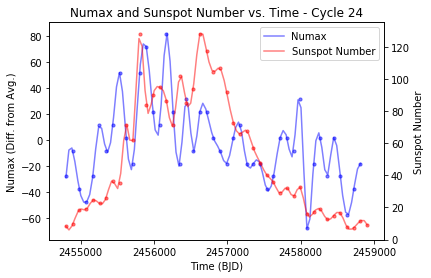

In [218]:
#Output SV vs. Time Cycle 24
datax_SV = numax_cycle_24_182[:-1].T[0]
#datay_SV = getResidual(numax_cycle_24_182[:-1]).T[1]
datay_SV = numax_cycle_24_182[:-1].T[1]
datax_SV_ITP, datay_SV_ITP = interpolate(numax_cycle_24_182[:-1],100)

data_SN = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_24),0),91.25)

datax_SN = data_SN.T[0] #np.subtract(data_SN.T[0],200)
datay_SN = data_SN.T[1]
datax_SN_ITP, datay_SN_ITP = interpolate(np.array([datax_SN,datay_SN]).T,100)


#Draw Plot
figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('Numax and Sunspot Number vs. Time - Cycle 24')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('Numax (Diff. from Avg.)')
axis_1.plot(datax_SV_ITP, datay_SV_ITP, c='blue', alpha=0.5, label = "Numax")
axis_1.scatter(datax_SV,datay_SV, s = 10, c='blue', alpha=0.5)

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('Sunspot Number')
axis_2.plot(datax_SN_ITP,datay_SN_ITP, c='red', alpha=0.5, label = "Sunspot Number")
axis_2.scatter(datax_SN,datay_SN, s = 10, c='red', alpha=0.5)

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)

#Show Plot
plt.savefig('Graphs/C24_Numax_SSN_Time.png')
plt.show()

45 45
[2454801.50054307 2454892.75054719 2454984.00055131 2455075.25055543
 2455166.50055956 2455257.75056368 2455349.0005678  2455440.25057192
 2455531.50057604 2455622.75058016]
[2454801.5 2454893.5 2454984.5 2455075.5 2455166.5 2455258.5 2455349.5
 2455440.5 2455531.5 2455623.5]


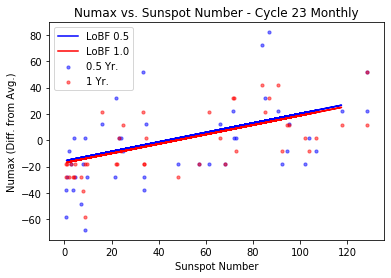

In [220]:
data_SV = getResidual(numax_cycle_24_182)[:-1].T[1]
data_SV2 = getResidual(numax_cycle_24_365)[:-1].T[1]
data_SN = getSNAverage(getSN_Day(cycle_24),91.25)[:-1].T[1]
print(len(data_SV),len(data_SN))
print(numax_cycle_24_182.T[0][0:10])
print(getSNAverage(getSN_Day(cycle_24),91.25).T[0][0:10])

#Draw Plot
plt.xlabel('Sunspot Number')
plt.ylabel('Numax (Diff. from Avg.)')
plt.title('Numax vs. Sunspot Number - Cycle 23 Monthly')
plt.autoscale(enable=True, axis='both', tight=None)

#Plot 1
plt.scatter(data_SN,data_SV, s=10, c='blue', alpha=0.5, label = "0.5 Yr.")
X_train, X_test, y_train, y_test = train_test_split(data_SN, data_SV, test_size = 1/3, random_state = 0)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
regressor = LinearRegression()
regressor.fit(X_train.reshape(-1,1), y_train)

y_pred = regressor.predict(X_test)
plt.plot(X_train, regressor.predict(X_train), color = 'blue', label = "LoBF 0.5")

#Plot 2
plt.scatter(data_SN,data_SV2, s=10, c='red', alpha=0.5, label = "1 Yr.")
X_train, X_test, y_train, y_test = train_test_split(data_SN, data_SV2, test_size = 1/3, random_state = 0)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
regressor = LinearRegression()
regressor.fit(X_train.reshape(-1,1), y_train)

y_pred = regressor.predict(X_test)
plt.plot(X_train, regressor.predict(X_train), color = 'red', label = "LoBF 1.0")

#Output
plt.legend()
plt.savefig('Graphs/C24_Numax_SSN.png')
plt.show()

In [221]:
#print(getResidual(numax_cycle_23_365).T[1])


[ -5.8   4.2  44.2  54.2  24.2  44.2  24.2  24.2  14.2  -5.8  -5.8   4.2
  14.2  34.2  14.2   4.2 -25.8 -25.8  -5.8  24.2  34.2  24.2  24.2  14.2
 -15.8  -5.8  -5.8  -5.8   4.2 -15.8 -25.8 -25.8 -25.8   4.2 -25.8  14.2
  -5.8 -25.8 -15.8 -25.8 -25.8 -25.8 -15.8 -15.8 -15.8  -5.8   4.2  -5.8
 -15.8 -25.8]
